# Analysis of the fluorescence recovery on parasite coats

The script gets its input from a config yml configuration file:
```yaml
filelist: /path/to/filelist.csv
summary: /path/to/results.csv
```
with filelist a csv file with columns 

|Filename| Start time [min]| First frame|
|--------|-----------------|------------|

where Filename column pointing to a TIF image file with a matching -profile.csv file with the columns 

|Frame|Time [min]|Mean Intensity|Fraction|
|-----|----------|--------------|--------|

Finally, summary is the path to a csv file with the result of the analysis by the imagej macro.

## Load dataset
Open the config.yaml file and load the intensity profile for each file listed in the filelist.

In [9]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def madstd(x):
    """Maximum abosolute deviation of the standard deviation"""
    return 1.4826 * np.median(np.abs(x-np.median(x)))



In [16]:
# Load the configuration file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

# Load the filelist in a dataframe
filelist = pd.read_csv(config['filelist'])

# Decode the parasite index
filelist['Parasite'] = filelist['Filename'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
filelist.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Define a loading function for the profile files
def load_profile(folder, row):
    path = folder / row['Filename'].replace('.tif','-profile.csv')
    df = pd.read_csv(path)
    df['Parasite'] = row['Parasite']
    df.drop(columns=['Fraction','Model'], inplace=True)
    return df
    

# Load the individual intensity profiles from *-profile.csv files saved by the ImageJ macro
folder = Path(config['filelist']).parent
df = pd.concat([load_profile(folder, row) for row in filelist.iloc], ignore_index=True)
df

,Frame,Time [min],Mean intensity,Parasite
0,1,60.499522,109.244914,1
1,2,60.999045,109.266181,1
2,3,61.498567,109.848418,1
3,4,61.998089,110.828181,1
4,5,62.497612,111.995481,1
...,...,...,...,...
984,86,105.023593,286.628032,27
985,87,106.023868,284.990274,27
986,88,107.024142,277.636123,27
987,89,108.024416,284.244560,27


## Visualization of intensity measurement

[Text(0.5, 0, 'Time p.i. [min]'),
 Text(0, 0.5, '% max GFP intensity around Gondi vacuole')]

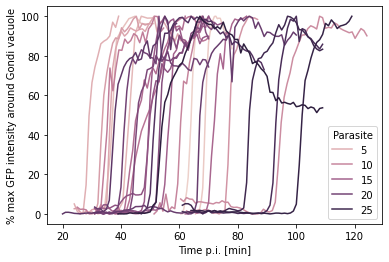

In [3]:


sns.lineplot(data=df, x='Time [min]', y='Normalized intensity', hue='Parasite')
plt.gca().set(xlabel='Time p.i. [min]',ylabel='% max GFP intensity around Gondi vacuole')

<AxesSubplot:xlabel='Time [min]', ylabel='Normalized model'>

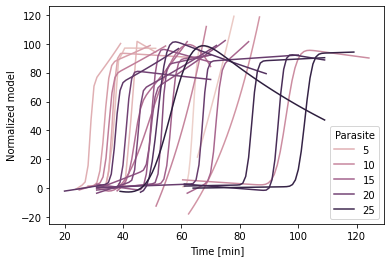

In [4]:
sns.lineplot(data=df, x='Time [min]', y='Normalized model', hue='Parasite')

(20.0, 120.0, 0.0, 1.0)

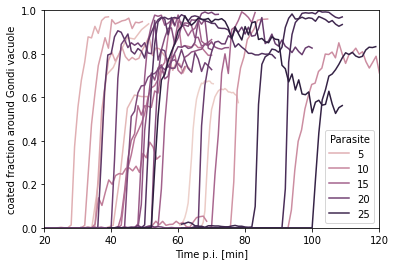

In [5]:
sns.lineplot(data=df, x='Time [min]', y='Fraction', hue='Parasite')
plt.gca().set(xlabel='Time p.i. [min]',ylabel='coated fraction around Gondi vacuole')
plt.axis([20,120,0,1])

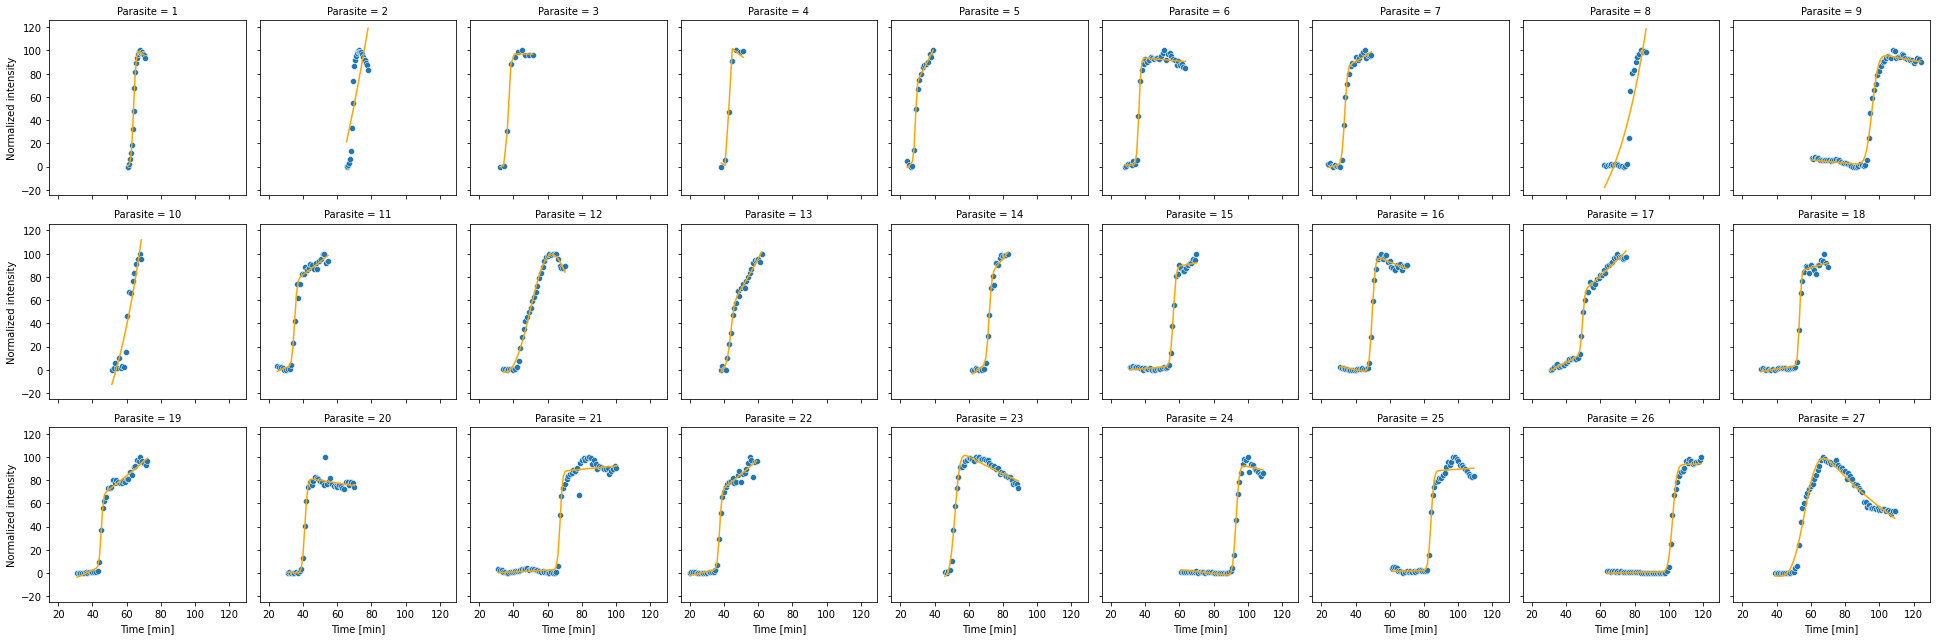

In [6]:
g = sns.FacetGrid(df, col="Parasite", col_wrap=9, despine=False)
g.map(sns.lineplot,'Time [min]', 'Normalized model',color='orange')
g.map(sns.scatterplot,'Time [min]', 'Normalized intensity')
#g.figure.subplots_adjust(wspace=0, hspace=0)

## Statistical analysis of model parameters


In [7]:
ds = pd.read_csv(config['summary'])
ds = pd.merge(ds,filelist[['Filename','Parasite']],left_on='Image',right_on='Filename')
ds.index = ds['Parasite']
ds = ds.sort_index()
ds.head()

,Image,Start time [min],First frame,Time mid point [min],Time constant [min],5%-95% recovery time [min],Intensity amplitude [au],Intensity offset [au],Photo-bleaching [min],R squared,...,Image slices,Image frames,Image pixel size,Image spacing,Image frame interval,Objective,Camera,Numerical Aperture,Filename,Parasite
Parasite,,,,,,,,,,,,,,,,,,,,,
1,Parasite1_from video on manuscript_211013_GFPR...,60,1,64.019091,1.734457,4.034347,14.965289,141.447443,418.382378,0.998928,...,17,21,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,Parasite1_from video on manuscript_211013_GFPR...,1
2,Parasite2_from video on manuscript_211013_GFPR...,60,11,68.843670,1.163282,2.705794,13.577282,121.474568,inf,0.990514,...,17,26,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,Parasite2_from video on manuscript_211013_GFPR...,2
3,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,30,1,36.924168,1.643539,3.822872,23.634799,143.299101,8346.282879,0.998662,...,13,10,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,3
4,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,30,4,42.815787,2.115019,4.919535,18.662892,139.589087,1989.578993,0.999954,...,13,7,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,4
5,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,23,1,28.800258,1.080676,2.513653,39.403926,138.168036,-53.133588,0.995248,...,9,16,0.233051,0.7,60.705688,Plan Fluor 40x Oil DIC H N2,Prime 95B A21B203017,1.30,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,5


Text(0.5, 0.98, 'Distribution of the model parameters')

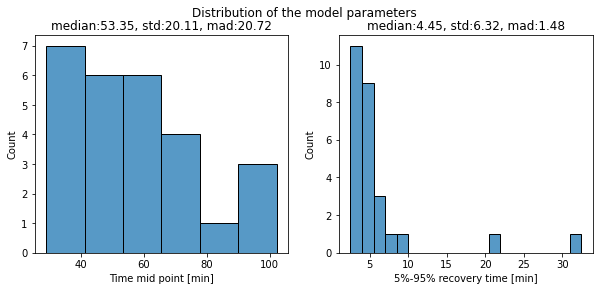

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(ds, x='Time mid point [min]')
t1 = ds['Time mid point [min]']
plt.title(f'median:{t1.median():.2f}, std:{t1.std():.2f}, mad:{madstd(t1):.2f}')
plt.subplot(122)
sns.histplot(ds, x='5%-95% recovery time [min]')
t2 = ds['5%-95% recovery time [min]']
plt.title(f'median:{t2.median():.2f}, std:{t2.std():.2f}, mad:{madstd(t2):.2f}');
plt.suptitle('Distribution of the model parameters')

## Interpolation of intensity on common time sampling

Text(42.0, 0.5, 'Parasite')

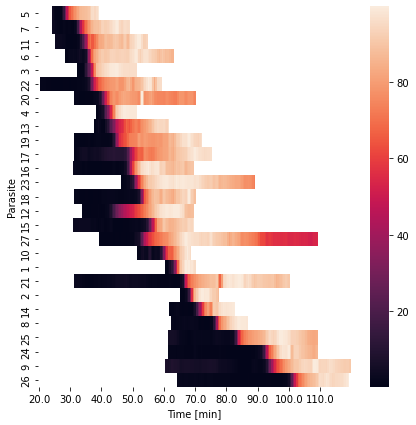

In [9]:
t = np.arange(20,120,0.5)
dst = {}
lng = []
for n,g in df.groupby('Parasite'):         
    tg = g['Time [min]']
    fg =  g['Normalized intensity']
    f = np.interp(t, tg, fg)
    f[t<tg.min()] = np.NaN
    f[t>tg.max()] = np.NaN
    dst[n] = f    

ptable = pd.DataFrame(dst)
ptable = ptable.reindex(columns=ptable.columns[np.argsort(ds['Time mid point [min]'])])
ptable.index = t
plt.figure(figsize=(7,7))
sns.heatmap(ptable.transpose(),xticklabels=20,linewidths=0.0, rasterized=True)
plt.xlabel('Time [min]')
plt.ylabel('Parasite')

In [10]:
ptable = pd.DataFrame(dst)
ptable.index = t
ptable.to_csv(folder/'interpolated_intensities.csv')

## Estimation of model parameters from intensity
Re-estimate the model instead of using the model saved in the summary.

Text(0.5, 0, '5%-95% recovery time [min]')

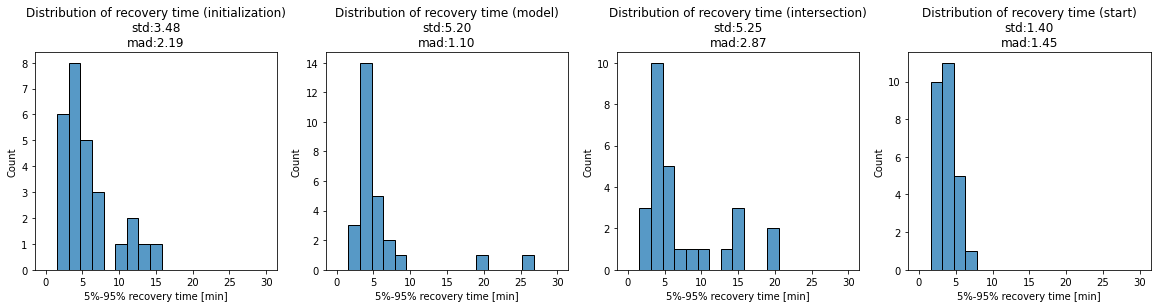

In [55]:
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.signal import medfilt

from math import exp

def fun(x,a,b,c,d,e):    
    """Error function + exponention"""
    return ( a + b * erf((x-c) / d) ) * np.exp(-e*x)

def init_params(x,y,alpha=0.2):    
    t0 = 0
    t1 = 0
    t2 = 0    
    y = medfilt(y,5)
    a,b  = y.min(), y.max()    
    corr = 2*erfinv(1-alpha)           
    for i, yi in enumerate(y):        
        if yi > a + alpha*(b-a) and t0 == 0:            
            t0 = np.interp(a + alpha*(b-a), y[i-2:i+2], x[i-2:i+2])
        if yi > a + (1-alpha)*(b-a) and t1 == 0:            
            t1 = np.interp(a + (1-alpha)*(b-a), y[i-2:i+2], x[i-2:i+2])
        if yi > a + 0.5*(b-a) and t2==0:
            t2 = np.interp(a + 0.5*(b-a), y[i-2:i+2], x[i-2:i+2])    
    return np.array([0.5*(a+b),0.5*(b-a),t2,(t1-t0)/corr,1e-6])

   
t = np.arange(20,120,0.5)
bg = 110

ds2 = [] # parameters
df2 = [] # intensity and models
mdl2 = [] # models for the all range of timepoints t
for n,g in df.groupby('Parasite'):     
    tg = np.array(g['Time [min]'])
    fg = np.array(g['Mean intensity'])
    idx = np.isfinite(fg)    
    tg = tg[idx]
    fg = medfilt(fg[idx], 3)
    bg = fg.min()
    fg = fg - fg.min()
    p0 = init_params(tg,fg,0.2)   
    r0 = ((fun(tg, *p0) - fg)**2).mean() 
    lb = [0.9*p0[0],0.9*p0[1],p0[2]-1,0.1*p0[3],-1]
    ub = [1.1*p0[0],1.1*p0[1],p0[2]+1,10*p0[3],1]        
    sigma = np.ones(tg.shape)
    sigma[tg<p0[2]+0.5*p0[3]] = 0.1
    popt, pcov = curve_fit(fun, tg, fg, p0)    
    r1 = ( (fun(tg, *popt) - fg)**2).mean()
    popt1, pcov1 = curve_fit(fun, tg, fg, popt,sigma=sigma)
    #sigma[tg<popt[2]+2*popt[3]] = 0.1
    #popt, pcov = curve_fit(fun, tg, fg, p0, sigma=sigma)   
    p1 = init_params(tg,fun(tg, *popt), 0.1)        
    ds2.append({
        'Parasite':n,
        'Init time mid point [min]':p0[2],
        'Model time mid point [min]':popt[2],
        'Model2 time mid point [min]':2.38 * popt1[2],
        'Intersection time mid point [min]':p1[2],
        'Time constant [min]':popt[3],
        'Init 5%-95% recovery time [min]':2.38 * p0[3],
        'Model 5%-95% recovery time [min]':2.38 * popt[3],
        'Model2 5%-95% recovery time [min]':2.38 * popt1[3],        
        'Intersection 5%-95% recovery time [min]':2.38 * p1[3],        
        'Intensity amplitude [au]': popt[1],
        'Intensity offset [au]': bg + popt[0],
        'Photo-bleaching [min]': 1/popt[4],
        'R2': 1 - r1 / ((fg - fg.mean())**2).mean()
    })
    
    g['Model'] = bg+fun(np.array(g['Time [min]']), *popt)
    g['Model2'] = bg+fun(np.array(g['Time [min]']), *popt1)
    g['Normalized model'] = 100*(g['Model'] - g['Model'].min()) / (g['Model'].max() - g['Model'].min())
    g['Normalized model2'] = 100*(g['Model2'] - g['Model2'].min()) / (g['Model2'].max() - g['Model2'].min())
    g['Normalized intensity'] = 100*(g['Mean intensity'] - g['Model'].min()) / (g['Model'].max() - g['Model'].min())    
    df2.append(g)
    mdl2.append(pd.DataFrame({'Parasite':n, 'Model':fun(t, *popt),'Time [min]':t,'Normalized model':100*fun(t,0.5,0.5,popt[2],popt[3],0)}))
    
df2 = pd.concat(df2)
df2.to_csv(folder / 'mean intensity and reestimated model.csv',index=False)

ds2 = pd.DataFrame.from_records(ds2)
ds2 = pd.merge(ds,ds2,left_on=ds.index,right_on='Parasite',suffixes=[' macro',' python']).drop(columns=['Parasite macro','Parasite python','Image'])
#ds2.index=ds2['Parasite']
ds2.to_excel(folder / 'reestimated model parameters.xlsx',index=False)

mdl2 = pd.concat(mdl2)
bins = np.linspace(0,30,20)
plt.figure(figsize=(20,4))
plt.subplot(141)
sns.histplot(ds2, x='Init 5%-95% recovery time [min]',bins=bins)
plt.title(f'Distribution of recovery time (initialization)\nstd:{ds2["Init 5%-95% recovery time [min]"].std():.2f}\nmad:{madstd(ds2["Init 5%-95% recovery time [min]"]):.2f}')
plt.xlabel('5%-95% recovery time [min]')
plt.subplot(142)
sns.histplot(ds2, x='Model 5%-95% recovery time [min]',bins=bins)
plt.title(f'Distribution of recovery time (model)\nstd:{ds2["Model 5%-95% recovery time [min]"].std():.2f}\nmad:{madstd(ds2["Model 5%-95% recovery time [min]"]):.2f}')
plt.xlabel('5%-95% recovery time [min]')
plt.subplot(143)
sns.histplot(ds2, x='Intersection 5%-95% recovery time [min]',bins=bins)
plt.title(f'Distribution of recovery time (intersection)\nstd:{ds2["Intersection 5%-95% recovery time [min]"].std():.2f}\nmad:{madstd(ds2["Intersection 5%-95% recovery time [min]"]):.2f}')
plt.xlabel('5%-95% recovery time [min]')
plt.subplot(144)
sns.histplot(ds2, x='Model2 5%-95% recovery time [min]',bins=bins)
plt.title(f'Distribution of recovery time (start)\nstd:{ds2["Model2 5%-95% recovery time [min]"].std():.2f}\nmad:{madstd(ds2["Model2 5%-95% recovery time [min]"]):.2f}')
plt.xlabel('5%-95% recovery time [min]')

#print(ds2['5%-95% recovery time [min]'].std(),madstd(ds2['5%-95% recovery time [min]']))
#print('Mean MSE', ds2['MSE'].mean())
#ds2[ds2['5%-95% recovery time [min]']>7]

In [56]:
ds2

,Parasite,Start time [min],First frame,Time mid point [min],Time constant [min] macro,5%-95% recovery time [min],Intensity amplitude [au] macro,Intensity offset [au] macro,Photo-bleaching [min] macro,R squared,...,Intersection time mid point [min],Time constant [min] python,Init 5%-95% recovery time [min],Model 5%-95% recovery time [min],Model2 5%-95% recovery time [min],Intersection 5%-95% recovery time [min],Intensity amplitude [au] python,Intensity offset [au] python,Photo-bleaching [min] python,R2
0,1,60,1,64.019091,1.734457,4.034347,14.965289,141.447443,418.382378,0.998928,...,63.997138,1.683056,2.455118,4.005673,4.240463,2.992780,27.667511,137.187430,79.649865,0.999239
1,2,60,11,68.843670,1.163282,2.705794,13.577282,121.474568,inf,0.990514,...,68.918472,1.429003,2.015744,3.401028,2.847796,2.559038,65.071103,172.449798,47.860295,0.997069
2,3,30,1,36.924168,1.643539,3.822872,23.634799,143.299101,8346.282879,0.998662,...,37.017840,1.631938,3.284774,3.884012,3.787167,3.645121,23.574318,142.752492,9877.358147,0.998997
3,4,30,4,42.815787,2.115019,4.919535,18.662892,139.589087,1989.578993,0.999954,...,42.821959,2.051228,3.883239,4.881923,4.796250,4.033154,17.918761,136.564604,8463.404639,0.999993
4,5,23,1,28.800258,1.080676,2.513653,39.403926,138.168036,-53.133588,0.995248,...,29.069481,1.286402,4.118838,3.061637,2.512419,6.091243,33.172724,191.039897,-34.228791,0.996707
5,6,23,5,36.389267,1.482883,3.449186,121.659374,302.148330,1249.062884,0.991291,...,36.387763,1.468025,2.695797,3.493901,2.190437,2.923856,123.066426,299.197487,803.209753,0.992217
6,7,23,1,33.624425,1.818053,4.228792,65.475557,176.615482,-174.817977,0.994601,...,33.819257,1.854797,4.310945,4.414416,2.251448,5.827184,56.554222,186.588213,-92.923611,0.995713
7,8,23,39,77.301672,1.592823,3.704905,75.160814,201.456333,inf,0.993670,...,77.253668,1.114782,2.835484,2.653180,2.367624,4.247065,11.343321,136.975697,-44.293634,0.998175
8,9,23,37,95.822837,4.087863,9.508369,88.656806,242.402536,640.069673,0.993894,...,95.636557,3.540382,6.458365,8.426109,6.155259,6.653367,69.886845,206.355178,-19190.566196,0.993402
9,10,23,28,60.987415,2.904512,6.755895,77.524412,282.922948,inf,0.979366,...,60.451991,1.102206,5.131886,2.623249,2.466339,5.715594,1.964207,204.616003,-18.416099,0.995248


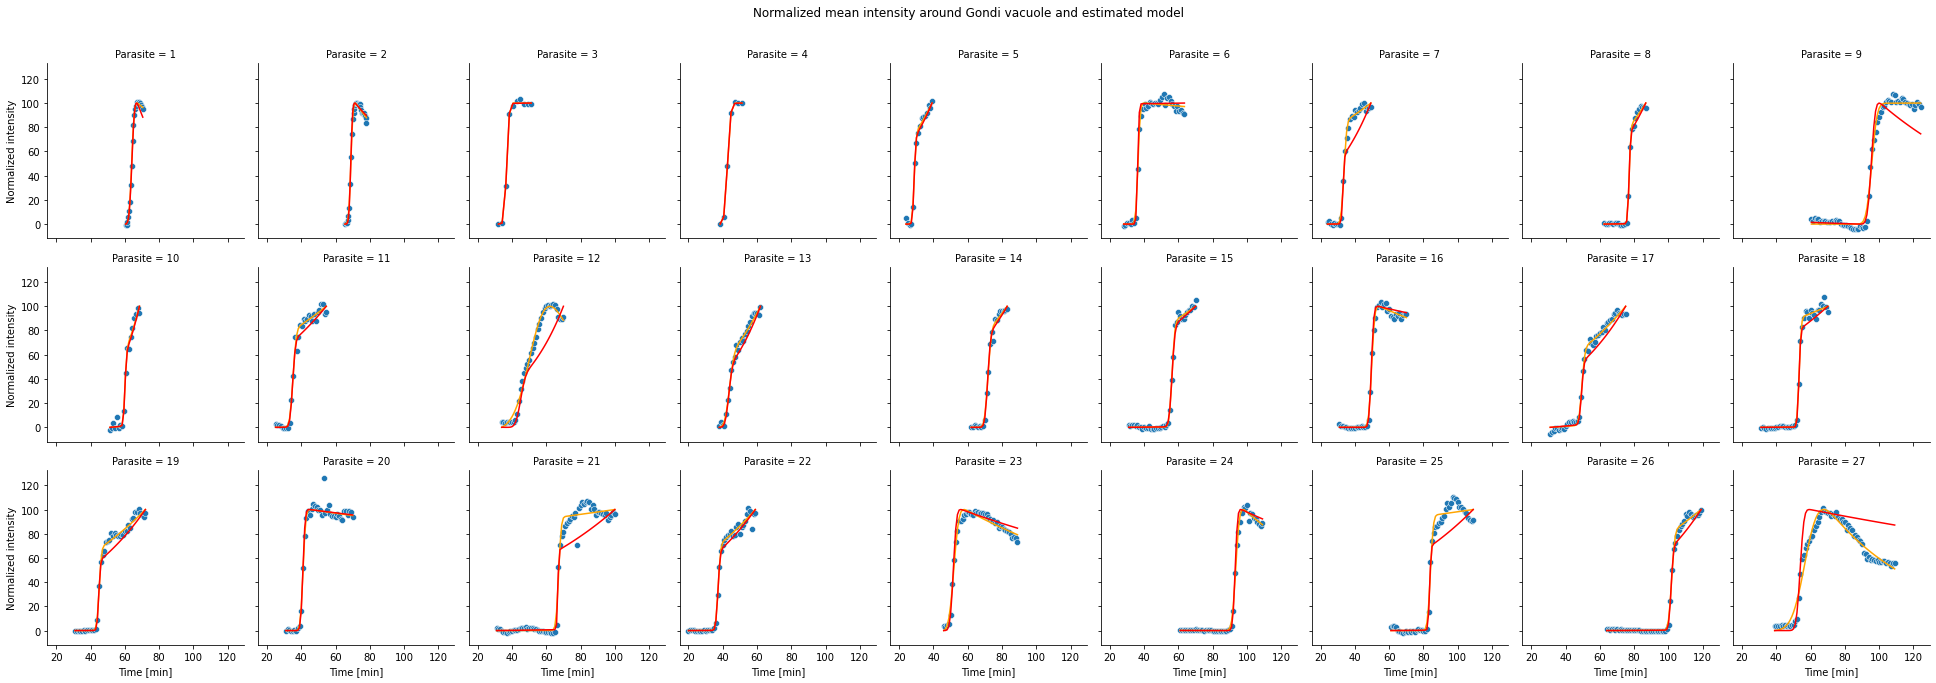

In [50]:
g = sns.FacetGrid(df2, col="Parasite", col_wrap=9, despine=True)
g.map(sns.lineplot,'Time [min]', 'Normalized model', color='orange')
g.map(sns.lineplot,'Time [min]', 'Normalized model2', color='red')
g.map(sns.scatterplot,'Time [min]', 'Normalized intensity')
plt.suptitle('Normalized mean intensity around Gondi vacuole and estimated model',y=1.05)
plt.savefig(folder / 'detailed-intensity-model-reestimated.pdf', bbox_inches='tight')

# Synchronized recovery
Synchronize intensity using the midpoint time.

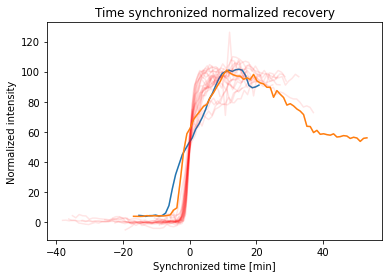

In [ ]:
outliers = ds2[ds2['Model 5%-95% recovery time [min]'] > 10]['Parasite']
for n,g in df2.groupby('Parasite'):
    c = ds2.loc[n]['Intersection time mid point [min]']    
    plt.plot( g['Time [min]']-c, g['Normalized intensity'],alpha=0.1,color='red')
    if n in outliers:
        plt.plot( g['Time [min]']-c, g['Normalized intensity'],alpha=1)
plt.title('Time synchronized normalized recovery')
plt.xlabel('Synchronized time [min]')
plt.ylabel('Normalized intensity')
plt.savefig(folder / 'sync-intensity.pdf', bbox_inches='tight')

## Interpolated intensity
Interpolate the signal and sort them by midpoint

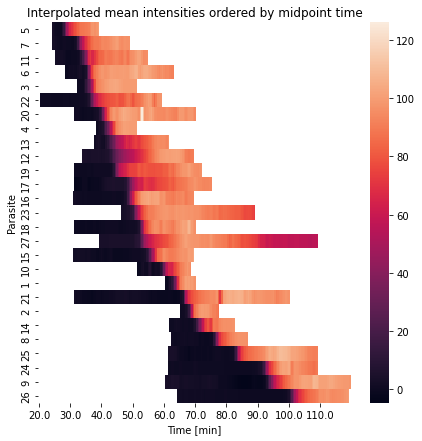

In [ ]:

t = np.arange(20,120,0.5)
dst = {}
lng = []
for n,g in df2.groupby('Parasite'):         
    tg = g['Time [min]']
    fg =  g['Normalized intensity']
    f = np.interp(t, tg, fg)
    f[t<tg.min()] = np.NaN
    f[t>tg.max()] = np.NaN
    dst[n] = f
    
ptable = pd.DataFrame(dst)
ptable = ptable.reindex(columns=ptable.columns[np.argsort(ds2['Model2 time mid point [min]'])])
ptable.index = t
plt.figure(figsize=(7,7))
sns.heatmap(ptable.transpose(),xticklabels=20, linewidths=0.0, rasterized=True)
plt.xlabel('Time [min]')
plt.ylabel('Parasite')
plt.title('Interpolated mean intensities ordered by midpoint time')
plt.savefig(folder / 'heatmap-intensity.pdf', bbox_inches='tight')

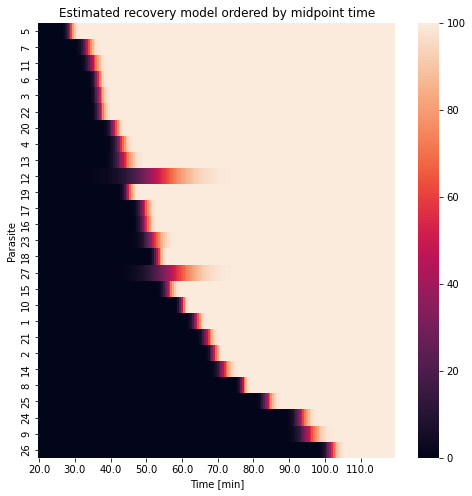

In [ ]:
plt.figure(figsize=(8,8))
ptable = mdl2.pivot_table('Normalized model','Time [min]','Parasite')
ptable = ptable.reindex(columns=ptable.columns[np.argsort(ds2['Model2 time mid point [min]'])])
sns.heatmap(ptable.transpose(),xticklabels=20,linewidths=0.0, rasterized=True)
plt.title('Estimated recovery model ordered by midpoint time')
plt.savefig(folder / 'heatmap-model-displayed-without-beaching.pdf', bbox_inches='tight')

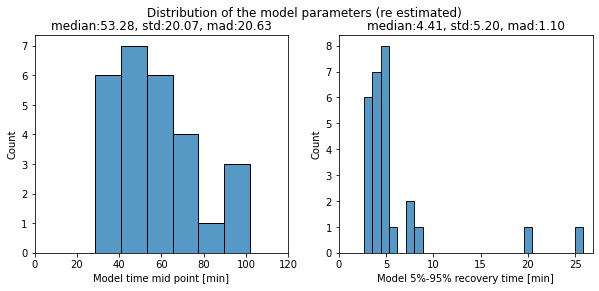

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(ds2, x='Model time mid point [min]')
plt.xlim([0,120])
t1 = ds2['Model time mid point [min]']
plt.title(f'median:{t1.median():.2f}, std:{t1.std():.2f}, mad:{madstd(t1):.2f}')
plt.subplot(122)
sns.histplot(ds2, x='Model 5%-95% recovery time [min]')
plt.xlim([0, 1+ds2['Model 5%-95% recovery time [min]'].max()])
t2 = ds2['Model 5%-95% recovery time [min]']
plt.title(f'median:{t2.median():.2f}, std:{t2.std():.2f}, mad:{madstd(t2):.2f}');
plt.suptitle('Distribution of the model parameters (re estimated)');
plt.savefig(folder / 'parameter-distribution.pdf', bbox_inches='tight')

## Visualization of the model

median 7


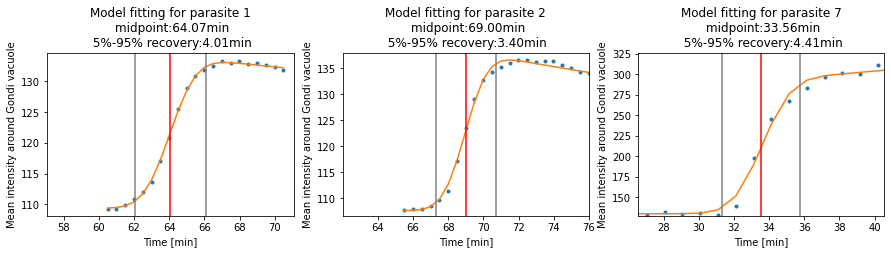

In [ ]:
# select a single curve
fig,ax = plt.subplots(1,3,figsize=(15,3))
kmedidx = np.argmin(np.abs(ds2['Model 5%-95% recovery time [min]'] - ds2['Model 5%-95% recovery time [min]'].median()))
medidx = ds2['Parasite'].iloc[kmedidx]
print('median', medidx)
for a,pid in zip(ax, [1,2,medidx]):        
    sel = df2[df2['Parasite']==pid]
    a.plot(sel['Time [min]'], sel['Mean intensity'],'.')
    a.plot(sel['Time [min]'], sel['Model'])
    #a = ds['Intensity offset [au]'][pid]
    #b = ds['Intensity amplitude [au]'][pid]
    c = ds2['Model time mid point [min]'][pid]
    t0 = ds2['Model 5%-95% recovery time [min]'][pid]    
    a.set(title=f'Model fitting for parasite {pid}\n midpoint:{c:.2f}min\n 5%-95% recovery:{t0:.2f}min', xlabel='Time [min]', ylabel='Mean intensity around Gondi vacuole')
    #plt.plot(sel['Time [min]'], a * np.ones(len(sel['Time [min]'])))
    #plt.plot(c * np.ones(2), np.linspace(120,130,2))
    #plt.plot(np.linspace(c-t0/2,c+t0/2,2),[125,125])
    a.plot([c-t0/2,c-t0/2],[0,500],color='gray')
    a.plot([c+t0/2,c+t0/2],[0,500],color='gray')
    a.plot([c,c],[0,500],color='red')
    a.axis([c-7,c+7,0.99*sel['Mean intensity'].min(),1.01*sel['Mean intensity'].max()])           
plt.savefig(folder / 'model-visualization.pdf', bbox_inches='tight')

## Save all data into a xlsx file

In [54]:
with pd.ExcelWriter(folder/'all data.xlsx') as xls:
    ds2.to_excel(xls,sheet_name='Summary',index=False)
    for n,g in df2.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)